In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import log

### Introduction

We will compare the 3 current techniques we have for 2D convolution

#### Direct

$$(CNKHWR^2,2 \cdot CNKHWR^2) $$

#### Winograd
We calculated earlier the flops needed are

$$\le 2KC \cdot M(R,\alpha,\alpha) + 2\frac{NHW}{m^2} \cdot M(\alpha, \alpha, \alpha) + \alpha^2N \cdot M(K,C,\frac{HW}{m^2}) + 2\frac{KNHW}{m^2} \cdot M(\alpha, \alpha, m ) $$

#### Doubly Toeplitz Fast Algorithm

$$(4CNKHWR^{1.16},\frac{8}{3} CNKHWR^{1.16}) $$

#### Chebyshev Toom-Cook Cosine Transform

To be done...

In [2]:
def simpleWinogradAlg_FLOPS(h,w,r,m,B,G,A,N,K,C,matmul):
    assert(h%m == 0 and w%m == 0)
    
    h-=2; w-=2
    
    P = (h//m)*(w//m) # num of tiles
    a = m+r-1 # input tile size
    
    dChunks = np.zeros((C,P,a,a))
    
    flops = np.zeros(2)
    
    U = np.zeros((a,a,K,C))
    g = np.zeros((r,r))
    temp = K * C * ( matmul(G,g) + matmul(g,G.T))
    flops += temp
            
    V = np.zeros((a,a,C,P))
    temp = N * P * C * ( matmul(B.T, dChunks[0,0]) + matmul(dChunks[0,0],B) )
    flops += temp
            
    M = np.zeros((a,a,K,P))
    # (K,C) x (C,P)
    temp = N * a * a * matmul(U[0,0],V[0,0])
    flops += temp
            
    Y = np.zeros((K,P,m,m))
    mInterm = np.zeros((a,a))
    temp = K * P * ( matmul(A.T, mInterm) + matmul(mInterm, A) )
    flops += temp
        
    # reorder
    return flops

def directMatmul(M1,M2):
    assert(M1.shape[1] == M2.shape[0])
    if(M2.shape[1] < 1000):
        pass
        # return M1.shape[1]**2 * np.log(M1.shape[1])/np.log(2)
    return M1.shape[0] * M1.shape[1] * M2.shape[1]

def direct2DConvFlops(C,N,K,H,W,R):
    return np.asarray([C*N*K*H*W*(R**2),2*C*N*K*H*W*(R**2)])

def doubleFast(C,N,K,H,W,R):
    return np.asarray([int(8 * N*W*R**1.16*K*C*H), int(4 * N*W*R**1.16*K*C*H)])

def FFTConvolution(C,N,K,H,W,R):
    A = H*W
    transformFlops = np.asarray([A * log(A,2) + 2*A, A * log(N,2) + A])
    flops = np.zeros(2)
    
    # data
    flops += C * N * transformFlops
    # filter
    flops += C * K * transformFlops
    # multiplications
    flops[1] += C * N * K * 2 * A
    # inverse transforms
    flops += C * N * K * transformFlops
    
    return np.asarray([2*flops[0] + 2*flops[1], 4*flops[1]])

def splitAddMul(M):
    return np.reshape(np.concatenate([M[::2],M[1::2]]), newshape=(2,-1))

In [3]:
N = 1
K = 96 # higher means more savings for multiplications
C = 3

M = 2; p = 8
H = M**p; W = M**p

directFlops = np.zeros(0)
winoFlops = np.zeros(0)
fastFlops = np.zeros(0)
fftFlops = np.zeros(0)
sizes = np.zeros(0)

for p in range(1,4):
    R = 2**p
    sizes = np.append(sizes,R)
    a = M + R - 1
    B = np.zeros((a,a)).T
    G = np.zeros((a,R))
    A = np.zeros((M,a)).T
    # h,w,r,m,B,G,A,N,K,C,matmul
    winoFlops = np.append(winoFlops, simpleWinogradAlg_FLOPS(H,W,R,M,B,G,A,N,K,C,directMatmul))
    # C,N,K,H,W,R
    directFlops = np.append(directFlops, direct2DConvFlops(C,N,K,H,W,R))
    fastFlops = np.append(fastFlops, doubleFast(C,N,K,H,W,R))
    fftFlops = np.append(fftFlops, FFTConvolution(C,N,K,H,W,R))
    
wino = splitAddMul(winoFlops)
direct = splitAddMul(directFlops)
fast = splitAddMul(fastFlops)
fourier = splitAddMul(fftFlops)

Text(0.5, 1.0, 'Savings for Fast Algorithm')

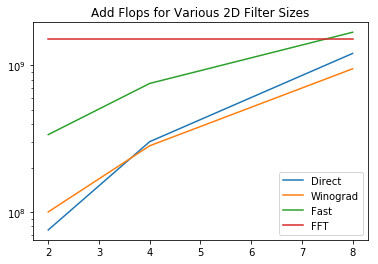

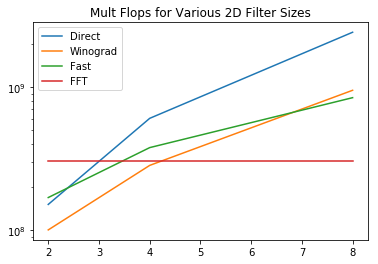

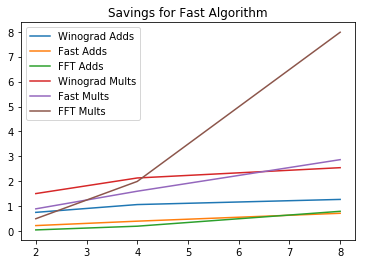

In [4]:
# add
plt.figure()
plt.semilogy(sizes,direct[0],label="Direct")
plt.semilogy(sizes,wino[0],label="Winograd")
plt.semilogy(sizes,fast[0],label="Fast")
plt.semilogy(sizes,fourier[0],label="FFT")
plt.title("Add Flops for Various 2D Filter Sizes")
plt.legend()

# mult
plt.figure()
plt.semilogy(sizes,direct[1],label="Direct")
plt.semilogy(sizes,wino[1],label="Winograd")
plt.semilogy(sizes,fast[1],label="Fast")
plt.semilogy(sizes,fourier[1],label="FFT")
plt.title("Mult Flops for Various 2D Filter Sizes")
plt.legend()

# mult savings
winoAddSavings = direct[0]/wino[0]
fastAddSavings = direct[0]/fast[0]
fftAddSavings = direct[0]/fourier[0]
winoMultSavings = direct[1]/wino[1]
fastMultSavings = direct[1]/fast[1]
fftMultSavings = direct[1]/fourier[1]
plt.figure()
plt.plot(sizes,winoAddSavings,label="Winograd Adds")
plt.plot(sizes,fastAddSavings,label="Fast Adds")
plt.plot(sizes,fftAddSavings,label="FFT Adds")
plt.plot(sizes,winoMultSavings,label="Winograd Mults")
plt.plot(sizes,fastMultSavings,label="Fast Mults")
plt.plot(sizes,fftMultSavings,label="FFT Mults")
plt.legend()
plt.title("Savings for Fast Algorithm")

In [5]:
N = 1
C = 3

R = 11
M = 2; p = 8
H = M**p; W = M**p

directFlops = np.zeros(0)
winoFlops = np.zeros(0)
fastFlops = np.zeros(0)
sizes = np.zeros(0)

for p in range(1,8):
    K = 2**p
    sizes = np.append(sizes,K)
    a = M + R - 1
    B = np.zeros((a,a)).T
    G = np.zeros((a,R))
    A = np.zeros((M,a)).T
    # h,w,r,m,B,G,A,N,K,C,matmul
    winoFlops = np.append(winoFlops, simpleWinogradAlg_FLOPS(H,W,R,M,B,G,A,N,K,C,directMatmul))
    # C,N,K,H,W,R
    directFlops = np.append(directFlops, direct2DConvFlops(C,N,K,H,W,R))
    fastFlops = np.append(fastFlops, doubleFast(C,N,K,H,W,R))
    
wino = splitAddMul(winoFlops)
direct = splitAddMul(directFlops)
fast = splitAddMul(fastFlops)

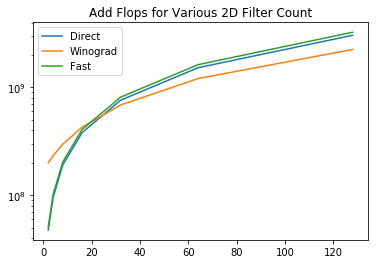

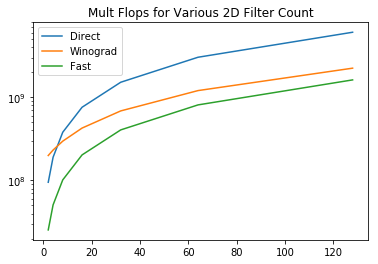

In [6]:
# add
plt.figure()
plt.plot(sizes,direct[0],label="Direct")
plt.plot(sizes,wino[0],label="Winograd")
plt.semilogy(sizes,fast[0],label="Fast")
plt.title("Add Flops for Various 2D Filter Count")
plt.legend()

# mult
plt.figure()
plt.plot(sizes,direct[1],label="Direct")
plt.plot(sizes,wino[1],label="Winograd")
plt.semilogy(sizes,fast[1],label="Fast")
plt.title("Mult Flops for Various 2D Filter Count")
plt.legend()